In [1]:
%matplotlib inline
import json
import os.path
import csv
import pandas as pd
import pylab as pl
from datetime import datetime as dt

In [2]:
NUM_USERS = 400
user_data = {}
call_logs = {}
contact_lists = {}
sms_logs = {}
user_status = {}

In [3]:
#initialize call logs, contact lists and sms logs to empty list
for i in range(1, NUM_USERS+1):
    call_logs[i] = []
    contact_lists[i] = []
    sms_logs[i] = []

#### Get the status of each user and save it as a dictionary

In [4]:
with open("../data/user_logs/user_status.csv", 'rb') as csvfile:
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # Rewind
    reader = csv.reader(csvfile)
    if has_header:
        next(reader)  # Skip header row
    for row in reader:
        user_id = int(row[0])
        user_status[user_id] = []
        user_status[user_id].append(row[1])  # disbursement time
        user_status[user_id].append(row[2])  # status

#### Get the call log, contact list, and sms log for each user and store them in their corresponding dictionaries.  While we're at it, get the number of devices

In [5]:
user_data["num_devices"] = []
for user_id in range(1, NUM_USERS+1):
    path = './../data/user_logs/user-' + str(user_id) + '/'
    devices = [name for name in os.listdir(path)]
    for device in devices:
        call_log_path = path + device + '/collated_call_log.txt'
        contact_list_path = path + device + '/collated_contact_list.txt'
        sms_log_path = path + device + '/collated_sms_log.txt'
        try:
            with open(call_log_path) as call_log_file:
                call_logs[user_id].extend(json.load(call_log_file))
        except IOError:
            #print "Error loading file"
            pass
        try:
            with open(contact_list_path) as contact_list_file:
                contact_lists[user_id].extend(json.load(contact_list_file))
        except IOError:
            #print "Error loading file"
            pass
        try:
            with open(sms_log_path) as sms_log_file:
                sms_logs[user_id].extend(json.load(sms_log_file))
        except IOError:
            #print "Error loading file"
            pass
    #print str(user_id) + ":",str(len(devices)), "devices"        
    user_data["num_devices"].append(len(devices))

#### Get some user statistics: number of calls, number of sms messages, number of contacts, number of devices

In [6]:
user_data["num_calls"] = []
user_data["num_contacts"] = []
user_data["num_sms"] = []
user_data["user_id"] = []
for user_id in range(1, NUM_USERS+1):
    user_data["user_id"].append(user_id)
    user_data["num_calls"].append(len(call_logs[user_id]))
    user_data["num_contacts"].append(len(contact_lists[user_id]))
    user_data["num_sms"].append(len(sms_logs[user_id]))

In [7]:
user_data_df = pd.DataFrame(data=user_data)
user_data_df.head()

,num_calls,num_contacts,num_devices,num_sms,user_id
0,182,246,1,133,1
1,1423,88,1,3773,2
2,442,200,1,125,3
3,1775,711,1,10522,4
4,2356,128,1,1654,5


#### Let's see what this dataset looks like

In [8]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].describe()

,num_calls,num_contacts,num_sms,num_devices
count,400.000000,400.000000,400.000000,400.000000
mean,1588.225000,573.585000,3336.160000,1.255000
std,1704.651581,1027.860431,6028.870615,0.718516
min,4.000000,14.000000,4.000000,1.000000
25%,500.000000,209.000000,410.250000,1.000000
50%,1000.000000,344.500000,1571.500000,1.000000
75%,2137.250000,594.750000,4443.500000,1.000000
max,11821.000000,13850.000000,86546.000000,7.000000


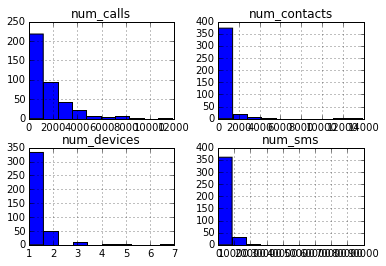

In [9]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].hist()
pl.show()

#### Let's see how many previous loans the users have been awarded. The intuition is that if a user has been awarded sevaral loans in the past, they will probably be more likely to repay this one. 

#### We will look at the user's sms messages to find messages that were sent by "Branch-Co" and start with "Your Branch loan of...", as this is what awarded loan sms messages look like.

In [10]:
def get_num_prev_loans(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    count_prev_loans = 0
    smss = sms_logs[user_id]
    for sms in smss:
        if "sms_address" in sms and "message_body" in sms and "datetime" in sms:
            if sms["sms_address"] == "Branch-Co" and sms["message_body"].startswith("Your Branch loan of"):
                sms_time = dt.fromtimestamp(float(sms["datetime"])/1000)

                if sms_time < loan_date:
                    count_prev_loans += 1
                    #print "disbursement_date:", disbursement_date
                    #print "->", sms["message_body"]
                    #print ">", sms_time
        #else:
            #print "~~~ ERROR ~~~"
    return count_prev_loans

In [12]:
for user in user_status:
    print "user", str(user) + ":", str(get_num_prev_loans(user, user_status[user][0])), "loans"

user 1: 1 loans
user 2: 1 loans
user 3: 0 loans
user 4: 0 loans
user 5: 0 loans
user 6: 0 loans
user 7: 1 loans
user 8: 0 loans
user 9: 0 loans
user 10: 0 loans
user 11: 1 loans
user 12: 0 loans
user 13: 0 loans
user 14: 0 loans
user 15: 0 loans
user 16: 0 loans
user 17: 0 loans
user 18: 0 loans
user 19: 1 loans
user 20: 1 loans
user 21: 0 loans
user 22: 0 loans
user 23: 0 loans
user 24: 0 loans
user 25: 0 loans
user 26: 0 loans
user 27: 0 loans
user 28: 0 loans
user 29: 0 loans
user 30: 1 loans
user 31: 0 loans
user 32: 0 loans
user 33: 1 loans
user 34: 0 loans
user 35: 0 loans
user 36: 0 loans
user 37: 0 loans
user 38: 0 loans
user 39: 0 loans
user 40: 0 loans
user 41: 0 loans
user 42: 0 loans
user 43: 0 loans
user 44: 0 loans
user 45: 1 loans
user 46: 0 loans
user 47: 0 loans
user 48: 0 loans
user 49: 0 loans
user 50: 0 loans
user 51: 0 loans
user 52: 1 loans
user 53: 0 loans
user 54: 0 loans
user 55: 0 loans
user 56: 0 loans
user 57: 0 loans
user 58: 0 loans
user 59: 0 loans
user 6

#### Some users have been awarded multiple loans (e.g. user 9 was awarded 12 loans), however, when we look at the time of these award sms messages, we see that they all happened before the current loan (i.e. the loan in the 'user_status.csv' file)
#### Looking at the results above, there are some users that seem to have one previous loan. However, taking a closer look at them, we can see that the award messages were sent late at night the night before the disbursement date.
#### This means that we are considering the users' first loans. This in turn means that not only can we not use previous loan information, but we also should disregard all messages (and calls) that happened after the disbursement date, which is in the future.

#### Let's remove those messages

In [13]:
def remove_user_post_disbursement_sms(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    smss = sms_logs[user_id]
#    print "disbursement_date:", disbursement_date
#    print str(len(smss)), "messages in all"
    past_messages = []
    for sms in smss:
        if "datetime" in sms:
            sms_time = dt.fromtimestamp(float(sms["datetime"])/1000)
            if sms_time < loan_date:   # keep this sms because it was received in the past
                past_messages.append(sms)               
#                print "->", sms["message_body"]
#                print ">", sms_time
    sms_logs[user_id] = past_messages
#    print str(len(past_messages)), "past messages"

In [14]:
def remove_user_post_disbursement_calls(user_id, disbursement_date):
    loan_date = dt.strptime(disbursement_date,"%Y-%m-%dT%H:%M:%S.%fZ")
    calls = call_logs[user_id]
#    print calls
#    print "disbursement_date:", disbursement_date
#    print str(len(calls)), "calls in all"
    past_calls = []
    for call in calls:
        if "datetime" in call:
            call_time = dt.fromtimestamp(float(call["datetime"])/1000)
            if call_time < loan_date:   # keep this call because it was received in the past
                past_calls.append(call)          
#                print ">", call_time
    call_logs[user_id] = past_calls
#    print str(len(past_calls)), "past calls"

In [15]:
for user in range(1, NUM_USERS+1):
    remove_user_post_disbursement_sms(user, user_status[user][0])
    remove_user_post_disbursement_calls(user, user_status[user][0])

#### Let's update our user stats to reflect only data collected before they were awarded the loan

In [16]:
user_data["num_calls"] = []
user_data["num_contacts"] = []
user_data["num_sms"] = []
user_data["user_id"] = []
for user_id in range(1, NUM_USERS+1):
    user_data["user_id"].append(user_id)
    user_data["num_calls"].append(len(call_logs[user_id]))
    user_data["num_contacts"].append(len(contact_lists[user_id]))
    user_data["num_sms"].append(len(sms_logs[user_id]))

In [17]:
user_data_df = pd.DataFrame(data=user_data)
user_data_df.head()

,num_calls,num_contacts,num_devices,num_sms,user_id
0,129,246,1,43,1
1,146,88,1,50,2
2,262,200,1,63,3
3,500,711,1,3371,4
4,452,128,1,118,5


In [18]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].describe()

,num_calls,num_contacts,num_sms,num_devices
count,400.0000,400.000000,400.000000,400.000000
mean,424.5675,573.585000,1677.120000,1.255000
std,301.5269,1027.860431,4370.563639,0.718516
min,0.0000,14.000000,0.000000,1.000000
25%,202.2500,209.000000,70.000000,1.000000
50%,493.0000,344.500000,423.500000,1.000000
75%,502.0000,594.750000,1594.000000,1.000000
max,2161.0000,13850.000000,68486.000000,7.000000


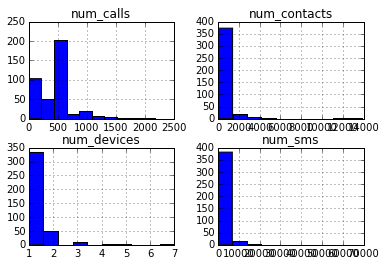

In [19]:
user_data_df[['num_calls','num_contacts','num_sms','num_devices']].hist()
pl.show()

#### Let's turn user_status into a dataframe

In [44]:
user_status_df = pd.DataFrame(data=user_status).T
user_status_df.head()
#user_data_df.columns = ['disbursement_date','status']
#user_status_df.head()

,0,1
1,2017-05-29T00:00:00.000Z,defaulted
2,2017-05-30T00:00:00.000Z,repaid
3,2017-05-26T00:00:00.000Z,defaulted
4,2017-05-31T00:00:00.000Z,repaid
5,2017-05-30T00:00:00.000Z,repaid


In [65]:
user_status_df.rename(columns={0: 'disbursement_date', 1: 'status'}, inplace=True)

In [66]:
user_status_df = user_status_df.assign(user_id = pd.Series(range(0,NUM_USERS+1)))

#### Now we want to calculate correlations between the features and the status. For that, we will join the two dataframes and turn status into a dummy (binary variable).  

In [67]:
df = user_status_df.set_index('user_id').join(user_data_df.set_index('user_id'))
df.head()

,disbursement_date,status,num_calls,num_contacts,num_devices,num_sms
user_id,,,,,,
1,2017-05-29T00:00:00.000Z,defaulted,129,246,1,43
2,2017-05-30T00:00:00.000Z,repaid,146,88,1,50
3,2017-05-26T00:00:00.000Z,defaulted,262,200,1,63
4,2017-05-31T00:00:00.000Z,repaid,500,711,1,3371
5,2017-05-30T00:00:00.000Z,repaid,452,128,1,118


In [71]:
df = pd.get_dummies(df, columns=["status"])

ValueError: labels ['status'] not contained in axis

In [70]:
df.corr(method="pearson")

,num_calls,num_contacts,num_devices,num_sms,status_defaulted,status_repaid
num_calls,1.000000,0.103046,0.347312,0.203023,-0.071767,0.071767
num_contacts,0.103046,1.000000,0.247630,0.073198,-0.117459,0.117459
num_devices,0.347312,0.247630,1.000000,0.051324,-0.139350,0.139350
num_sms,0.203023,0.073198,0.051324,1.000000,-0.028584,0.028584
status_defaulted,-0.071767,-0.117459,-0.139350,-0.028584,1.000000,-1.000000
status_repaid,0.071767,0.117459,0.139350,0.028584,-1.000000,1.000000
